# Segmenting nuclei with the `stardist` napari plugin

## Overview

Plugins extend the functionality of napari and can be combined together to build
workflows. Many plugins exist for common analysis tasks such as segmentation and
filtering. In this activity, we will segment nuclei using the
[stardist napari plugin](https://github.com/stardist/stardist-napari). Please
visit the [napari hub](https://www.napari-hub.org/) for a listing of the
available plugins.

### Data source

The data were downloaded from the
[OpticalPooledScreens github repository](https://github.com/feldman4/OpticalPooledScreens).

## Data source

The data were downloaded from the
[OpticalPooledScreens github repository](https://github.com/feldman4/OpticalPooledScreens).

## Loading the data

We will start by loading an image of DAPI stained nuclei. We can use
`scikit-image`'s `imread()` function to download the data from the link below
and load it into a numpy array called `nuclei`.

In [1]:
from skimage import io

url = 'https://raw.githubusercontent.com/kevinyamauchi/napari-spot-detection-tutorial/main/data/nuclei_cropped.tif'
nuclei = io.imread(url)

## Viewing the image

In [2]:
# this cell is required to run these notebooks on Binder. Make sure that you also have a desktop tab open.
import os
if 'BINDER_SERVICE_HOST' in os.environ:
    os.environ['DISPLAY'] = ':1.0'

As we did in the previous notebooks, we can view the image in napari using the
`napari.view_image()` function. Here we set the colormap to `magma`.

In [3]:
import napari

viewer = napari.view_image(nuclei, colormap='magma')

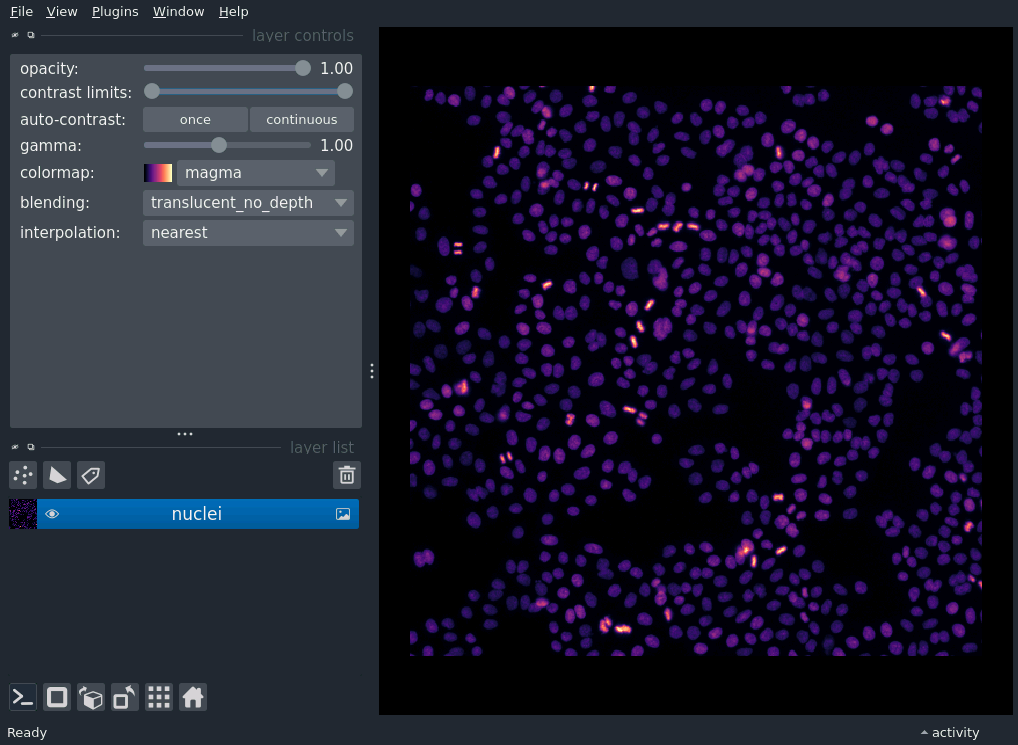

In [4]:
from napari.utils import nbscreenshot

nbscreenshot(viewer)

## Segment nuclei

To segment the nuclei, we will use the
[stardist napari plugin](https://github.com/stardist/stardist-napari). Please
perform the segmentation using the instructions below. For more information on
stardist, please see the
[papers](https://github.com/stardist/stardist#stardist---object-detection-with-star-convex-shapes)
and [repository](https://github.com/stardist/stardist).

1. Start the stardist plugin. From the menu bar, click
   Plugins->stardist-napari:StarDist. You should see the plugin added to the
   right side of the viewer. Note it may take a while for the plugin to first
   open, as it downloads some pre-trained models for you.

```{image} resources/stardist_plugin.png
:alt: stardist plugin
:width: 80%
:align: center
```

2. Select the "nuclei" image layer.

```{image} resources/stardist_screenshots_image_selection.png
:alt: select the image layer
:width: 80%
:align: center
```

3. Set the model type to "2D"

```{image} resources/stardist_screenshots_model_type_selection.png
:alt: select the 2D model
:width: 80%
:align: center
```

4. Select the "Versatile (fluorescent nuclei)" pretrained model

```{image} resources/stardist_screenshots_model_selection.png
:alt: select the Versatile model
:width: 80%
:align: center
```

5. Check the "Normalize Image" checkbox and set the low and high percentiles to
   1.00 and 99.80, respectively. Normalizing the image is important to ensure
   the intensity distribution is as similar as possible to the distribution the
   stardist model was trained on.

```{image} resources/stardist_screenshots_preprocessing.png
:alt: check the normalize image box
:width: 80%
:align: center
```

6. You can leave the postprocessing options as their default values. Setting the
   "Probability / Score Threshold" to  higher values will likely reduce false
   positives, but also lead to fewer segmented objects. Increasing the "Overlap
   Threshold" will allow objects to overlap more. Feel free to play around with
   the settings!

7. You can leave the "Advanced Options" as their default values

8. You are now ready to perform the segmentation! Press the "Run" button to
   start the segmentation. This may take a few minutes as we are running the
   computation on CPU. However, this would be much faster when using a GPU!

```{image} resources/stardist_screenshots_run.png
:alt: check the normalize image box
:width: 80%
:align: center
```

9. When the segmentation is complete, you should see the results in the viewer.
   Two layers have been added to the viewer. "StarDist polygons" contains the
   outlines of the segmented cells as polygons as a Shapes layer and "StarDist
   labels" contains the dense instance segmentation as a Labels layer.

```{image} resources/stardist_screenshots_segmentation.png
:alt: check the normalize image box
:width: 80%
:align: center
```

#  Bonus: Quantify nuclei shape

In this next section, we will compute and display some basic properties of the
segmented cells (e.g., area) using scikit-image and matplotlib.

## Measure area and perimeter
`stardist` outputs the segmentation masks as a label image in a `Labels` layer
called `'StarDist labels'`. In napari, we can access the layer data from the
layer object's `data` property. As we did in the previous exercise, we can
access the the layer object from the layer list by its name
(`viewer.layers['StarDist labels']`). From that layer object, we can access the
data.

We can use the scikit-image
[`regionprops_table`](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops_table)
function to measure the area and perimeter of the detected nuclei.
`regionprops_table` outputs a dictionary where each key is a name of a
measurement (e.g., `'area'`) and the value is the measurement value for each
detected object (nucleus in the case).`

In [5]:
from skimage.io import imread

label_im = imread('./data/stardist_masks.tif')
viewer.add_labels(label_im, name='StarDist labels')

<Labels layer 'StarDist labels' at 0x7fed586f05b0>

In [6]:
from skimage.measure import regionprops_table

# measure the area and nucleus for each nucleus
label_layer = viewer.layers['StarDist labels']
rp_table = regionprops_table(
    label_layer.data,
    properties=('area', 'perimeter')
)

In [ ]:
from matplotlib import pyplot as plt
import numpy as np


# print the median area
median_area = np.median(rp_table['area'])
print(f'median area: {median_area} px')

# plot a histogram of the areas
plt.hist(rp_table['area']);
plt.xlabel('nucleus area', fontsize=20);
plt.ylabel('count', fontsize=20);
plt.show();

Finally, we can calculate the circularity from the area and perimeter
measurements we made above. The circularity is a shape factor that is 1 when the
object is a circle and less than one for shapes that are more "starfish-like".
The circularity is defined as

$$f_{circ} = \frac{4 \pi A}{P^2}$$

where A is the area and P is the perimeter of the object. We plot the
circularity vs. the area and see that the circularity of the nuclei does not
appear to depend on the area.

In [ ]:
# calculate the circularity of the nuclei
circularity = (4 * np.pi * rp_table['area']) / np.square(rp_table['perimeter'])

# use matplot lib to visualize the relationship between nucleus circularity and area
plt.scatter(rp_table['area'], circularity);
plt.xlabel('nucleus area', fontsize=20);
plt.ylabel('circularity', fontsize=20);
plt.ylim((0, 2))
plt.show()

## Conclusions

In this notebook, we have used the stardist-napari plugin to perform nucleus
segmentation. We then used the results of the segmentation to inspect the
relationship between nucleus area and circularity. This demonstration highlights
how one can combine napari plugins and python libraries to make measurements on
microscopy data.